In [38]:
import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax


def cal_ratio_within_bins(data, bins):
    binsc = np.zeros(len(bins)-1)
    ratio = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        indi = (data>bins[i]) & (data<=bins[i+1])
        ratio[i] = np.sum(indi)/np.sum(~np.isnan(data))
        binsc[i] = (bins[i]+bins[i+1])/2
    return binsc, ratio



In [53]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

# input/out and iteration information
iternum = 6
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/'

In [54]:
    # LSE metrics

    df_sse_metric = []

    for tarbasin in range(len(df_info)):
    # for tarbasin in range(5):
        for i in range(iternum):
            infile = f'{inpath_moasmo}/level1_{tarbasin}_calib/ctsm_outputs_SSEnormKGE/iter{i}_many_metrics_mizuroute_s-1.csv'    
            dfi = pd.read_csv(infile)
            dfi['basin'] = tarbasin
            dfi['iter'] = i
            dfi['trial'] = np.arange(len(dfi))
            if len(df_sse_metric) == 0:
                df_sse_metric = dfi
            else:
                df_sse_metric = pd.concat([df_sse_metric, dfi])

In [55]:
# check nan ratio of each iteration
metname = 'kge'
nanratio = np.nan * np.zeros([len(df_info), iternum]) # best; mean; median
for i in range(iternum):
    indi = (df_sse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_sse_metric['basin']==j)
        dij = df_sse_metric[indij][metname].values
        nanratio[j, i] = np.sum(np.isnan(dij)) / len(dij)

print('nan ratio of each iteration')
print(np.nanmean(nanratio, axis=0))

nan ratio of each iteration
[0.0092823  0.01393939 0.01665072 0.01655502 0.01400319 0.01486443]


In [56]:
# statistics-1: best metric of each iteration
metname = 'kge'
met_defa = np.nan * np.zeros(len(df_info))
met_stats_sse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_sse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_sse_metric['basin']==j)
        dij = df_sse_metric[indij][metname].values

        met_stats_sse[j, i, 0] = np.nanmax(dij)
        met_stats_sse[j, i, 1] = np.nanmean(dij)
        met_stats_sse[j, i, 2] = np.nanmedian(dij)

        if i == 0:
            met_defa[j] = dij[0]

print('median defa:', np.nanmedian(met_defa))
print('best of each iteration')
print(np.nanmedian(met_stats_sse[:,:,0], axis=0))
print(np.nanmean(met_stats_sse[:,:,0], axis=0))

median defa: 0.2924950605896708
best of each iteration
[0.50298218 0.53746934 0.58326784 0.60245882 0.61976184 0.63540527]
[0.46907225 0.47157003 0.52196694 0.54740216 0.57762143 0.58302699]


In [57]:
# statistics-2: best metric of all iterations (e.g., for iter-2, this is the best from iter0+iter1+iter2)

metname = 'kge'
met_defa = np.nan * np.zeros(len(df_info))
met_stats_sse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_sse_metric['iter']<=i)
    for j in range(len(df_info)):
        indij = indi & (df_sse_metric['basin']==j)
        dij = df_sse_metric[indij][metname].values

        met_stats_sse[j, i, 0] = np.nanmax(dij)
        met_stats_sse[j, i, 1] = np.nanmean(dij)
        met_stats_sse[j, i, 2] = np.nanmedian(dij)

        if i == 0:
            met_defa[j] = dij[0]

print('median defa:', np.nanmedian(met_defa))
print('best of each iteration')
print(np.nanmedian(met_stats_sse[:,:,0], axis=0))
print(np.nanmean(met_stats_sse[:,:,0], axis=0))

median defa: 0.2924950605896708
best of each iteration
[0.50298218 0.54971426 0.58821192 0.603999   0.62301765 0.63541968]
[0.46907225 0.51143333 0.54380697 0.56357214 0.58166272 0.59405867]


(0.0, 1.0)

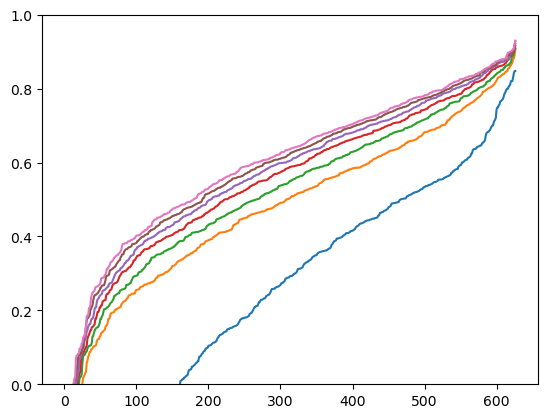

In [58]:
plt.plot(np.sort(met_defa))
for i in range(iternum):
    plt.plot(np.sort(met_stats_sse[:,i,0]))

plt.ylim(0,1)

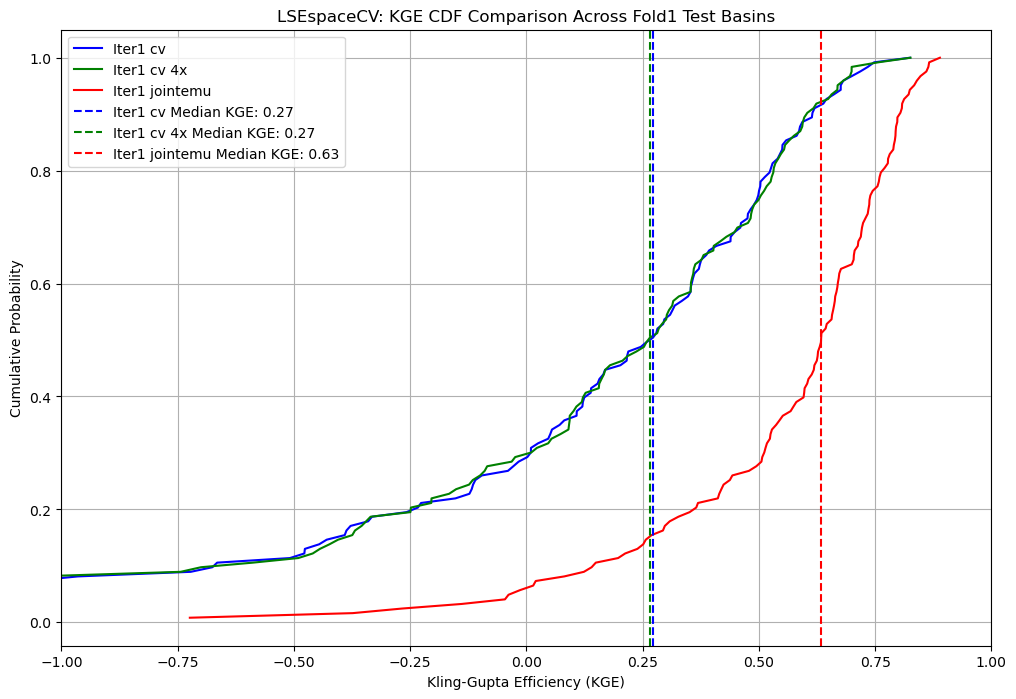

In [66]:
def list_folders(parent_directory):
    folders = [f for f in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, f))]
    return folders
    

# Initialize a dictionary to collect KGE values for each iteration and comparison
kge_values = {
    'iter1_CV': [],
    'iter1_CV_4X': [],
    'iter1_jointemu': []}

# Number of samples for iteration 1
num_samples = 100

# List of basins to exclude for iteration 1
excluded_basins = ['09484600', '02427250','12025000','10166430']

# List of basins from path_archive_1test
Basin_list = list_folders('/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/param_sets_LSEspaceCV_1test')

# Loop through each basin from path_archive_1test
for basin_name in Basin_list:
    path_CV = f'/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV/{basin_name}/'
    path_CV_4X = f'/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_LSEspaceCV_1test/{basin_name}/'
    path_jointemu = f'/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/moasmo_evaluation_jointemu/{basin_name}/'

    if basin_name in excluded_basins:
        continue

    # Read and process KGE values for iter-1 from all three paths
    try:
        # From path_CV (Cross-validation path)
        objfuncs_iter1_CV = pd.read_csv(f'{path_CV}/iter1_all_metric.csv')
        kge_best_values_CV = objfuncs_iter1_CV['kge'].values[:num_samples]
        kge_best_values_CV = kge_best_values_CV[~np.isnan(kge_best_values_CV)]  # Remove NaN values
        if len(kge_best_values_CV) > 0:
            kge_values['iter1_CV'].append(np.max(kge_best_values_CV))

        # From path_CV_4X (Cross-validation 4X path)
        objfuncs_iter1_CV_4X = pd.read_csv(f'{path_CV_4X}/iter1_all_metric.csv')
        kge_best_values_CV_4X = objfuncs_iter1_CV_4X['kge'].values[:num_samples]
        kge_best_values_CV_4X = kge_best_values_CV_4X[~np.isnan(kge_best_values_CV_4X)]  # Remove NaN values
        if len(kge_best_values_CV_4X) > 0:
            kge_values['iter1_CV_4X'].append(np.max(kge_best_values_CV_4X))

        # From path_jointemu (joint emulator path)
        objfuncs_iter1_jointemu = pd.read_csv(f'{path_jointemu}/iter1_all_metric.csv')
        kge_best_values_jointemu = objfuncs_iter1_jointemu['kge'].values[:num_samples]
        kge_best_values_jointemu = kge_best_values_jointemu[~np.isnan(kge_best_values_jointemu)]  # Remove NaN values
        if len(kge_best_values_jointemu) > 0:
            kge_values['iter1_jointemu'].append(np.max(kge_best_values_jointemu))

    except FileNotFoundError as e:
        print(f"File not found for basin {basin_name}: {e}")
        continue

# Compute CDF values for each comparison (CV, CV_4X, jointemu)
cdf_data = {}
for iter_name, kge_list in kge_values.items():
    sorted_kge = np.sort(kge_list)
    cdf_data[iter_name] = (sorted_kge, np.arange(1, len(sorted_kge) + 1) / len(sorted_kge))

# Plot the CDFs for iter1_CV, iter1_CV_4X, and iter1_jointemu
plt.figure(figsize=(12, 8))

# Define color map for the comparison
color_map = {
    'iter1_CV': 'blue',
    'iter1_CV_4X': 'green',
    'iter1_jointemu': 'red'
}

# Plot the CDFs for iter1_CV, iter1_CV_4X, and iter1_jointemu
for iter_name, (sorted_kge, cdf) in cdf_data.items():
    plt.plot(sorted_kge, cdf, label=f'{iter_name.replace("_", " ").capitalize()}', color=color_map[iter_name])

# Add vertical lines for median values using the same color as the corresponding CDF line
for iter_name, kge_list in kge_values.items():
    if len(kge_list) > 0:
        median_value = np.nanmedian(kge_list)
        plt.axvline(x=median_value, color=color_map[iter_name], linestyle='--', 
                    label=f'{iter_name.replace("_", " ").capitalize()} Median KGE: {median_value:.2f}')

plt.title('LSEspaceCV: KGE CDF Comparison Across Fold1 Test Basins')
plt.xlabel('Kling-Gupta Efficiency (KGE)')
plt.ylabel('Cumulative Probability')
plt.xlim([-1.0, 1.0])
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
# plt.savefig('kge_cdf_comparison_iter1_CV_CV_4X_jointemu.png', format='png', dpi=300)
plt.show()

In [63]:
kge_best_values_CV_4X.shape

(100,)